In [1]:
!uv pip install -q --system numba-cuda==0.4.0
!pip install pynvjitlink-cu12

import numpy as np
from numba import cuda
import time
import os
from numba import config
import numba
config.CUDA_ENABLE_PYNVJITLINK=1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 22.5 MB/s eta 0:00:00


In [2]:
# ex1_vector_add.py
import numpy as np
from numba import cuda
import math
import time
import numba

@numba.cuda.jit
def vector_add_kernel(a, b, c):
  """
  Each thrad computes one element: c[i] = a[i] + b[i]
  """
  #compute global thread indexx
  idx = cuda.grid(1)

  #boundary check
  if idx < c.size:
    c[idx] = a[idx] + b [idx]

def main ():
  N_large = 10_000_000
  a = np.random.randn(N_large).astype(np.float32)
  b = np.random.randn(N_large).astype(np.float32)
  c = np.zeros(N_large, dtype=np.float32)

  d_a = cuda.to_device(a)
  d_b = cuda.to_device(b)
  d_c = cuda.to_device(c)

  threads_per_block =256
  blocks_per_grid = math.ceil(N_large / threads_per_block)

  # Warmup
  vector_add_kernel[blocks_per_grid, threads_per_block](d_a, d_b, d_c)
  cuda.synchronize()

  # GPU timing
  start = time.time()
  vector_add_kernel[blocks_per_grid, threads_per_block](d_a, d_b, d_c)
  cuda.synchronize()
  gpu_time = (time.time() - start) * 1000

  result = d_c.copy_to_host()



  # CPU timing
  cpu_start = time.time()
  expected = a + b
  cpu_time = (time.time() - cpu_start) * 1000

  print(f"GPU kernel time: {gpu_time:.3f} ms")
  print(f"CPU NumPy time: {cpu_time:.3f} ms")
  print(f"Speedup: {cpu_time / gpu_time:.2f}x")
  print("Correct:", np.allclose(result, expected))

if __name__ == "__main__":
  main()


GPU kernel time: 0.626 ms
CPU NumPy time: 46.412 ms
Speedup: 74.16x
Correct: True


In [3]:

import numpy as np
from numba import cuda
import math
import time
import numba

@numba.cuda.jit
def dummy_compute_kernel(a, b, c):
  """
  simple compute to measure timing : c[i] = sqrt(a[i]^2 + b[i]^2)
  """

  idx = cuda.grid(1)
  if idx < c.size:
    c[idx] = math.sqrt(a[idx]**2 + b[idx]**2)


def main ():
  N_large = 1_000_000    #1M elements
  a = np.random.randn(N_large).astype(np.float32)
  b = np.random.randn(N_large).astype(np.float32)
  c = np.zeros(N_large, dtype=np.float32)

  d_a = cuda.to_device(a)
  d_b = cuda.to_device(b)
  d_c = cuda.to_device(c)

  threads_per_block =256
  blocks_per_grid = math.ceil(N_large / threads_per_block)

  # Warmup
  dummy_compute_kernel[blocks_per_grid, threads_per_block](d_a, d_b, d_c)
  cuda.synchronize()

  # GPU timing
  start = time.time()
  dummy_compute_kernel[blocks_per_grid, threads_per_block](d_a, d_b, d_c)
  cuda.synchronize()
  end = time.time()

  gpu_time = (end - start) * 1000    #convert to ms

  result = d_c.copy_to_host()



  # CPU timing
  cpu_start = time.time()
  expected = np.sqrt(a**2 + b**2)

  cpu_time = (time.time() - cpu_start) * 1000

  print(f"GPU kernel time: {gpu_time:.3f} ms")
  print(f"CPU NumPy time: {cpu_time:.3f} ms")
  print(f"Speedup: {cpu_time / gpu_time:.2f}x")
  print("Correct:", np.allclose(result, expected))

if __name__ == "__main__":
  main()


GPU kernel time: 0.175 ms
CPU NumPy time: 44.015 ms
Speedup: 251.52x
Correct: True


In [4]:

import numpy as np
from numba import cuda
import math
import time
import numba

@numba.cuda.jit
def matrix_scale_kernel(mat, scalar, out):
  """
  scale every element: out[row, col] = mat[row, col] * scalar
  """

  row, col = cuda.grid(2)
  if row < out.shape[0] and col < out.shape[1]:
    out[row, col] = mat[row, col] * scalar


def main ():
  rows_large, cols_large = 4096, 4096
  mat =  np.random.randn(rows_large, cols_large).astype(np.float32)
  out = np.zeros_like(mat)
  scalar = 2.5
  d_mat = cuda.to_device(mat)
  d_out = cuda.to_device(out)

  threads_per_block = (32, 32)
  blocks_per_grid_x = math.ceil(rows_large / threads_per_block[0])
  blocks_per_grid_y = math.ceil(cols_large / threads_per_block[1])
  blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

  # Warmup
  matrix_scale_kernel[blocks_per_grid, threads_per_block](d_mat, scalar, d_out)
  cuda.synchronize()

  # GPU timing
  start = time.time()
  matrix_scale_kernel[blocks_per_grid, threads_per_block](d_mat, scalar, d_out)
  cuda.synchronize()
  gpu_time = (time.time() - start) * 1000    #convert to ms

  result = d_out.copy_to_host()

  # CPU timing
  cpu_start = time.time()
  expected = mat * scalar
  cpu_time = (time.time() - cpu_start) * 1000

  print(f"GPU kernel time: {gpu_time:.3f} ms")
  print(f"CPU NumPy time: {cpu_time:.3f} ms")
  print(f"Speedup: {cpu_time / gpu_time:.2f}x")
  print("Correct:", np.allclose(result, expected))

if __name__ == "__main__":
  main()


GPU kernel time: 4.163 ms
CPU NumPy time: 20.171 ms
Speedup: 4.85x
Correct: True


In [5]:
# Matrix Multiplicatiion
import numpy as np
from numba import cuda
import math
import time
import numba

@numba.cuda.jit
def matmul_naive_kernel(A, B, C):
  """
  Naive matrix multiply: C = A @ B
  each thread computes one element og C.
  All reads from A and B ggo to global memory (slow). Alter: shared memory

  A: (M,K)
  B: (K,N)
  c: (M,N)
  """

  row, col = cuda.grid(2)

  M, K = A.shape
  K2, N = B.shape

  if row < M and col < N:
    total = 0.0
    for k in range(K):
      total += A[row, k] * B [k, col]
    C[row, col] = total


def main ():
  M, K, N = 1000, 1000, 1000
  A = np.random.randn(M, K).astype(np.float32)
  B = np.random.randn(K, N).astype(np.float32)
  C = np.zeros((M, N), dtype=np.float32)

  threads_per_block = (32, 32)
  d_A = cuda.to_device(A)
  d_B = cuda.to_device(B)
  d_C = cuda.to_device(C)


  blocks_per_grid_x = (M + threads_per_block[0] - 1) // threads_per_block[0]
  blocks_per_grid_y = (N + threads_per_block[1] - 1) // threads_per_block[1]
  blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

  # Warmup
  matmul_naive_kernel[blocks_per_grid, threads_per_block](d_A, d_B, d_C)
  cuda.synchronize()

  # GPU timing
  start = time.time()
  matmul_naive_kernel[blocks_per_grid, threads_per_block](d_A, d_B, d_C)
  cuda.synchronize()
  gpu_time = (time.time() - start) * 1000    #convert to ms

  C_gpu = d_C.copy_to_host()

  # CPU timing
  cpu_start = time.time()
  C_cpu = A @ B
  cpu_time = (time.time() - cpu_start) * 1000

  print(f"GPU kernel time: {gpu_time:.3f} ms")
  print(f"CPU NumPy time: {cpu_time:.3f} ms")
  print(f"Speedup: {cpu_time / gpu_time:.2f}x")
  print(f"Correct: {np.allclose(C_gpu, C_cpu, atol=1e-3)}")

if __name__ == "__main__":
  main()


GPU kernel time: 52.032 ms
CPU NumPy time: 39.524 ms
Speedup: 0.76x
Correct: True


Image: 3840x2160 (8,294,400 pixels)
Grid: (240, 135) blocks x (32, 32) threads

Results
GPU: 48.52 ms
CPU: 39.68 ms
Speedup: 0.8x
Correct: False


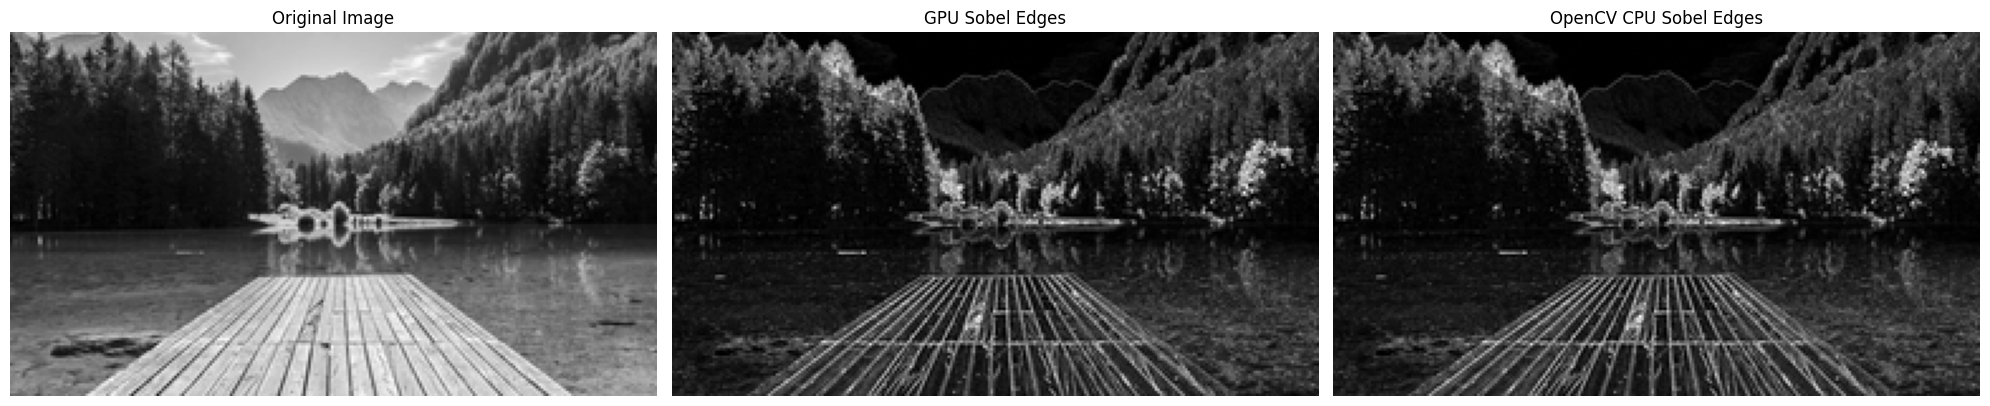

In [16]:
import numpy as np
import numba.cuda as cuda
import time
import urllib.request
from PIL import Image
from matplotlib import pyplot as plt
import cv2

@numba.cuda.jit
def sobel_kernel(img, out):
  """
  Apply sobel edge detection -each thread processes one pixel
  """
  row, col = cuda.grid(2)
  H, W = img.shape

  if 0 < row < H-1 and 0 < col < W-1:
    #Horizontal Gradient (Gx)
    gx = (-img[row-1,col-1] + img[row-1,col+1] +
          -2*img[row,col-1] +2*img[row,col+1] +
          -img[row+1,col-1] + img[row+1,col+1])

    # Vertical Gradient
    gy = (-img[row-1,col-1] - 2*img[row-1,col] - img[row-1,col+1] +
          img[row+1,col-1] + 2*img[row+1,col] + img[row+1,col+1])

    # Edge magnitude
    out[row, col] = (gx*gx + gy*gy)**0.5

def sobel_opencv(img):
    """OpenCv CPU version using Sobel"""
    gx = cv2.Sobel(img,cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img,cv2.CV_32F, 0, 1, ksize=3)
    return np.sqrt(gx**2 + gy**2)

# Load 4K image from internet
urllib.request.urlretrieve("https://picsum.photos/3840/2160", "image.jpg")
img = Image.open("image.jpg").convert('L')  #Convert to grayscale
img = np.array(img, dtype=np.float32)

H, W = img.shape
print(f"Image: {W}x{H} ({W*H:,} pixels)")

d_img = cuda.to_device(img)
d_out = cuda.to_device(np.zeros_like(img))

threads = (32, 32)
blocks = ((W + 15) // 16, (H + 15) // 16)

print(f"Grid: {blocks} blocks x {threads} threads")

# Warmup
sobel_kernel[blocks, threads](d_img, d_out)
cuda.synchronize

# Time run
start = time.time()
sobel_kernel[blocks, threads](d_img, d_out)
cuda.synchronize()
gpu_time = (time.time() - start) * 1000

out_gpu = d_out.copy_to_host()

start = time.time()
out_cpu = sobel_opencv(img)
cpu_time = (time.time() - start) * 1000

# Results
print("\n" + "="*60)
print("Results")
print("="*60)
print(f"GPU: {gpu_time:.2f} ms")
print(f"CPU: {cpu_time:.2f} ms")
print(f"Speedup: {cpu_time/gpu_time:.1f}x")
print(f"Correct: {np.allclose(out_gpu, out_cpu, atol=1e-3)}")

# Resize for display
H, W = img.shape
target_w = 256
target_h = int(target_w * H / W)

def resize_for_plot(array):
    normalized = (array / array.max() * 255).astype(np.uint8)
    return np.array(Image.fromarray(normalized).resize((target_w, target_h), Image.LANCZOS))

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(resize_for_plot(img), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(resize_for_plot(out_gpu), cmap='gray')
plt.title('GPU Sobel Edges')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(resize_for_plot(out_cpu), cmap='gray')
plt.title('OpenCV CPU Sobel Edges')
plt.axis('off')

plt.tight_layout()
plt.show()